# Tutorial: Train image classification model

## Set up your development environment
All the setup for your development work can be accomplished in a Python notebook. Setup includes the following actions:

* Import Python packages.
* Connect to a workspace, so that your local computer can communicate with remote resources.
* Create an experiment to track all your runs.
* Create a remote compute target to use for training.

### Import packages
Import Python packages you need in this session. Also display the Azure Machine Learning SDK version:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.83


### load workspace configuration from the config.json file in the current folder.

In [2]:
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

duvitech-ml	eastus	duvitech-dev


In [3]:
from azureml.core import Experiment
experiment_name = 'sklearn-mnist'

exp = Experiment(workspace=ws, name=experiment_name)

### Create or attach an existing compute target

By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,
                                                                min_nodes=compute_min_nodes,
                                                                max_nodes=compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(
        ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-01-21T00:02:28.326000+00:00', 'errors': None, 'creationTime': '2020-01-21T00:02:24.681117+00:00', 'modifiedTime': '2020-01-21T00:02:41.832711+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


### Download the MNIST dataset

Use Azure Open Datasets to get the raw MNIST data files. Azure Open Datasets are curated public datasets that you can use to add scenario-specific features to machine learning solutions for more accurate models. Each dataset has a corresponding class, MNIST in this case, to retrieve the data in different ways.

In [5]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

### Display some sample images

Load the compressed files into numpy arrays. Then use matplotlib to plot 30 random images from the dataset with their labels above them. This step requires a load_data function that's included in an util.py file. This file is included in the sample folder. Make sure it's placed in the same folder as this notebook. The load_data function simply parses the compressed files into numpy arrays.

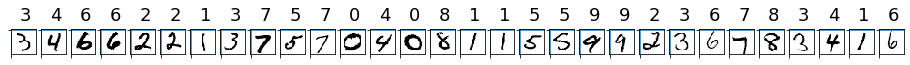

In [7]:
# make sure utils.py is in the same directory as this code
import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, "train-images-idx3-ubyte.gz"), False) / 255.0
X_test = load_data(os.path.join(data_folder, "t10k-images-idx3-ubyte.gz"), False) / 255.0
y_train = load_data(os.path.join(data_folder, "train-labels-idx1-ubyte.gz"), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, "t10k-labels-idx1-ubyte.gz"), True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [8]:
script_folder = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called train.py in the directory you just created.

In [10]:
%%writefile $script_folder/train.py

import argparse
import gzip
import os
import numpy as np
import glob
import struct

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Overwriting C:\CURRENT-WORK\uofr-dev\ml-azure-dev\classification-ex\sklearn-mnist/train.py


### Create an estimator

An SKLearn estimator object is used to submit the run. Create your estimator by running the following code to define these items:

* The name of the estimator object, est.
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution.
* The compute target. In this case, you use the Azure Machine Learning compute cluster you created.
* The training script name, train.py.
* Parameters required from the training script.

In this tutorial, this target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for run. The data_folder is set to use the dataset. First create an environment object that specifies the dependencies required for training.

In [11]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

env = Environment('my_env')
cd = CondaDependencies.create(pip_packages=['azureml-sdk','scikit-learn','azureml-dataprep[pandas,fuse]>=1.1.14'])
env.python.conda_dependencies = cd

Then create the estimator with the following code

In [12]:
from azureml.train.sklearn import SKLearn

script_params = {
    '--data-folder': mnist_file_dataset.as_named_input('mnist_opendataset').as_mount(),
    '--regularization': 0.5
}

est = SKLearn(source_directory=script_folder,
              script_params=script_params,
              compute_target=compute_target,
              environment_definition=env, 
              entry_script='train.py')

WARNING - If environment_definition or conda_dependencies_file_path is specified, Azure ML will not install any framework related packages on behalf of the user.
WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


### Submit the job to the cluster

Run the experiment by submitting the estimator object:

In [13]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
sklearn-mnist,sklearn-mnist_1579565493_f45295b7,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


### Jupyter widget

Watch the progress of the run with a Jupyter widget. Like the run submission, the widget is asynchronous and provides live updates every 10 to 15 seconds until the job finishes:

In [20]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Get log results upon completion

Model training and monitoring happen in the background. Wait until the model has finished training before you run more code. Use wait_for_completion to show when the model training is finished:
    

In [16]:
run.wait_for_completion(show_output=False)  # specify True for a verbose log


{'runId': 'sklearn-mnist_1579565493_f45295b7',
 'target': 'cpucluster',
 'status': 'Finalizing',
 'startTimeUtc': '2020-01-21T00:16:05.625726Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'a582cfc9-26ce-4af1-a621-649deeab0b0c',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'e99d094d-aef8-4a87-a73c-70b1a6eb24cf'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist_opendataset', 'mechanism': 'Mount'}}],
 'runDefinition': {'script': 'train.py',
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:mnist_opendataset',
   '--regularization',
   '0.5'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpucluster',
  'dataReferences': {},
  'data': {'mnist_opendataset': {'dataLocation': {'dataset': {'id': 'e99d094d-aef8-4a87-a73c-70b1a6eb24cf'},
     'dataPath': None},
    'crea

### Display run results

You now have a model trained on a remote cluster. Retrieve the accuracy of the model:

In [17]:
print(run.get_metrics())

{'regularization rate': 0.5, 'accuracy': 0.9193}


### Register model

The last step in the training script wrote the file outputs/sklearn_mnist_model.pkl in a directory named outputs in the VM of the cluster where the job is run. outputs is a special directory in that all content in this directory is automatically uploaded to your workspace. This content appears in the run record in the experiment under your workspace. So the model file is now also available in your workspace.

You can see files associated with that run:

In [18]:
print(run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_be79286f6224ad537949d166c94690f80ccad965a3254ef5c005705b9dabaf6b_d.txt', 'azureml-logs/65_job_prep-tvmps_be79286f6224ad537949d166c94690f80ccad965a3254ef5c005705b9dabaf6b_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_be79286f6224ad537949d166c94690f80ccad965a3254ef5c005705b9dabaf6b_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/142_azureml.log', 'logs/azureml/job_prep_azureml.log', 'outputs/sklearn_mnist_model.pkl']


Register the model in the workspace, so that you or other collaborators can later query, examine, and deploy this model:

In [19]:
# register model
model = run.register_model(model_name='sklearn_mnist',
                           model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist	sklearn_mnist:4	4


### Clean up resources

If you don't plan to use the resources you created, delete them, so you don't incur any charges:

Delete resource group to delete everything 

You can also delete just the Azure Machine Learning Compute cluster. However, autoscale is turned on, and the cluster minimum is zero. So this particular resource won't incur additional compute charges when not in use:

In [ ]:
# Optionally, delete the Azure Machine Learning Compute cluster
compute_target.delete()